In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
from pathlib import Path
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F

from models import VAE_Encoder, VAE_Decoder, SISVAE
from data_loader import DataGenerator
from utils import process_config, create_dirs
from train import load_latest_vae_checkpoint

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # keep GPU ordering consistent
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
# load VAE model
config = process_config('config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir'], config['checkpoint_dir_lstm']])
# create your data generator
data = DataGenerator(config)

In [5]:
# create a VAE model and load the latest checkpoint
encoder = VAE_Encoder(config).to(device)
decoder = VAE_Decoder(config).to(device)
model = SISVAE(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), amsgrad=True)

if not load_latest_vae_checkpoint(model, optimizer, device, config['checkpoint_dir']):
    raise RuntimeError("No checkpoint found to load.")
model.eval()

Loaded VAE checkpoint: experiments/local-results/sis-vae/batch-256/sis-vae-256-128-40/checkpoint/vae_checkpoint_epoch_625.pth


SISVAE(
  (encoder): VAE_Encoder(
    (gru): GRU(67, 200, batch_first=True)
    (z_mean_layer): Linear(in_features=200, out_features=40, bias=True)
    (z_log_var_layer): Linear(in_features=200, out_features=40, bias=True)
  )
  (decoder): VAE_Decoder(
    (gru): GRU(40, 200, batch_first=True)
    (Xhat_mean_layer): Linear(in_features=200, out_features=67, bias=True)
    (Xhat_log_var_layer): Linear(in_features=200, out_features=67, bias=True)
  )
)

In [6]:
def evaluate_vae(model, data):
    # Inference
    with torch.no_grad():
        X = torch.from_numpy(data).float()
        X = X.to(device)

        reconstruction = model(X)

        mean = reconstruction[0]
        std = torch.exp(0.5 * reconstruction[1])
        Xhat = reconstruction[2]
        recon_error = torch.sum((X - Xhat).pow(2)).cpu().numpy()

        mean = mean.cpu().numpy()
        std = std.cpu().numpy()

    return recon_error, [mean, std]

In [7]:
data_dir = Path('../data')
train_df = pd.read_csv(data_dir / 'train.csv')
train_df = train_df.drop(columns=['subject_id', 'label'])

train_m = train_df.mean().values[0]
train_std = train_df.std().values[0]

train_df_with_anomaly = pd.read_csv(data_dir / 'train_with_anomaly.csv')
train_df_subjects_with_anomaly = train_df_with_anomaly.pop('subject_id')
train_df_labels_with_anomaly = train_df_with_anomaly.pop('label')

test_df = pd.read_csv(data_dir / 'test.csv')
test_subjects = test_df.pop('subject_id')
test_labels = test_df.pop('label')

In [8]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.argwhere(test_anomaly_metric.flatten() > threshold_1)
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

In [9]:
val_score = []
for sequence in tqdm(data.val_set_vae['data']):
    # Inference on validation data
    score, recon = evaluate_vae(model, sequence)
    # Reduce windows to scalars through percentile
    val_score.append(np.percentile(score, 100))
val_score = np.vstack(val_score)

100%|██████████| 94/94 [00:00<00:00, 118.45it/s]


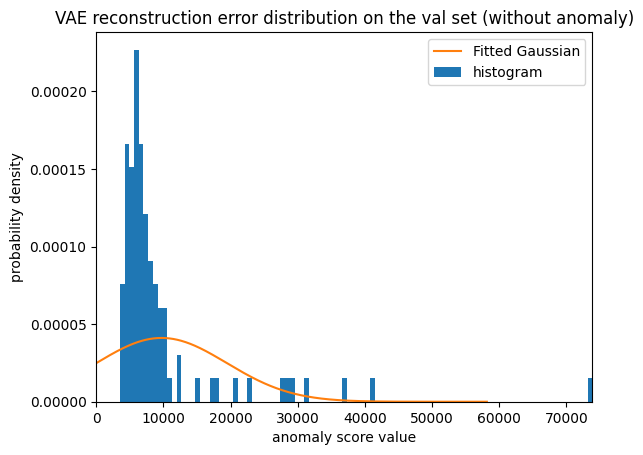

25% percentile: 5418.6826171875
75% percentile: 9002.0224609375
These windows scored the top 1% of anomaly metric (43502.87890625): 
[[26]]


(np.float32(9724.986), np.float32(9707.583))

In [10]:
plot_histogram(val_score, 100, 'VAE reconstruction error distribution on the val set (without anomaly)', mean=None, std=None, xlim=None)

In [11]:
# Evaluate test data
test_score = []
for sequence in tqdm(data.test_set_vae['data']):
    # Inference on sequence
    score, recon = evaluate_vae(model, sequence)
    score = np.percentile(score, 100)
    # Find maximum error in anomaly score sequence
    test_score.append(score)
test_score = np.vstack(test_score)

100%|██████████| 348/348 [00:02<00:00, 134.19it/s]


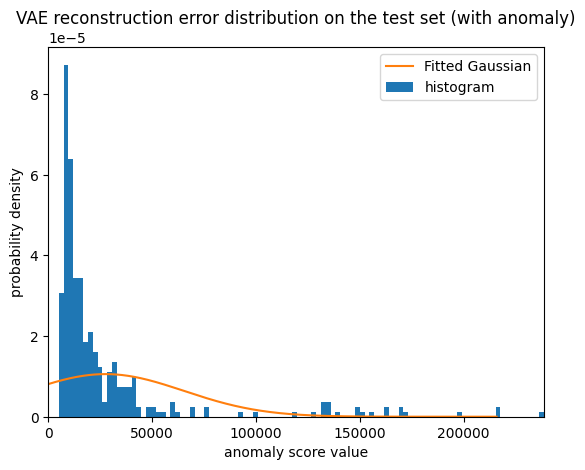

25% percentile: 9576.263671875
75% percentile: 27385.953125
These windows scored the top 1% of anomaly metric (185436.109375): 
[[38]
 [39]
 [64]
 [65]]


(np.float32(27609.791), np.float32(37731.883))

In [12]:
plot_histogram(test_score, 100, 'VAE reconstruction error distribution on the test set (with anomaly)', mean=None, std=None, xlim=None)

In [13]:
n_test_vae = (test_labels.shape[0] - config['window_size']) // config['window_shift'] + 1
test_labels_vae = np.zeros(n_test_vae)
anomaly_index_vae = []
for i in tqdm(range(n_test_vae)):
    idx_start = i * config['window_shift']
    idx_end = idx_start + config['window_size']
    
    test_labels_vae[i] = np.max(test_labels[idx_start:idx_end])
    if test_labels_vae[i] == 1:
        anomaly_index_vae.append(np.arange(idx_start, idx_end))

print(test_labels_vae.shape)

100%|██████████| 348/348 [00:00<00:00, 33396.28it/s]

(348,)


In [14]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    idx_error = np.flatnonzero(test_anomaly_metric > threshold)
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    return idx_error

In [15]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    idx_detected_anomaly_set = set(idx_detected_anomaly)
    idx_detected_anomaly_extended = set(idx_detected_anomaly)
    
    # anomaly_index는 이상 구간(리스트의 리스트)이라고 가정
    for anomaly_win in anomaly_index:
        # 현재 이상 구간(anomaly_win)이 기존 탐지에 포함되었는지 확인
        # set intersection이 빠름
        if idx_detected_anomaly_set.intersection(anomaly_win):
            # 포함되었다면 해당 구간 전체를 확장된 set에 추가
            idx_detected_anomaly_extended.update(anomaly_win)

    # numpy로 변환 후 정렬
    return np.sort(np.array(list(idx_detected_anomaly_extended), dtype=int))

In [16]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):  
    detected_labels = test_labels[idx_detected_anomaly]
    n_TP = np.sum(detected_labels == 1)
    n_FP = np.sum(detected_labels == 0)
    n_FN = np.sum(test_labels == 1) - n_TP
    
    return n_TP, n_FP, n_FN

In [17]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    precision = n_TP / (n_TP + n_FP) if (n_TP + n_FP) > 0 else 1.0
    recall = n_TP / (n_TP + n_FN) if (n_TP + n_FN) > 0 else 0.0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [18]:
# Now select a threshold
threshold = np.percentile(val_score, 100)

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_score, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_vae)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_vae, 
                                                                       test_labels_vae)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 73863.421875

PR evaluation using augmented detection:
Precision: 0.7307692307692307
Recall: 0.16521739130434782
F1: 0.2695035460992907
TP: 19
FP: 7
FN: 96


In [19]:
def slice_detected_indices_into_seq(idx_detection, interval): # interval: max gap between consecutive indices in a sequence
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [20]:
def plot_detected_anomalies(idx_detection, config, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    interval = config['window_size'] // config['window_shift']
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test[:, 0]) # plot only the first channel
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r-')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j * config['window_shift'] + config['window_size']) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j * config['window_shift'] + config['window_size']) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')

    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(0.8 * y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0] * config['window_shift'], detected_seq[i][-1] * config['window_shift'] + config['window_size']])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title(f"dataset test sequence\n(normalised by train mean {result['train_m']:.4f} and std {result['train_std']:.4f})\n Detection method: {detection_method}")
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

In [21]:
result = {}
result['t_test'] = test_df.index.values
result['test'] = (test_df.values - train_m) / train_std
result['train_m'] = train_m
result['train_std'] = train_std
result['t_unit'] = '0.25 sec'
result['idx_anomaly_test'] = np.flatnonzero(test_labels.values == 1)

Detected 4 sequences


/tmp/ipykernel_86064/4187010438.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/tmp/ipykernel_86064/4187010438.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/home/peunsu/ml_project/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


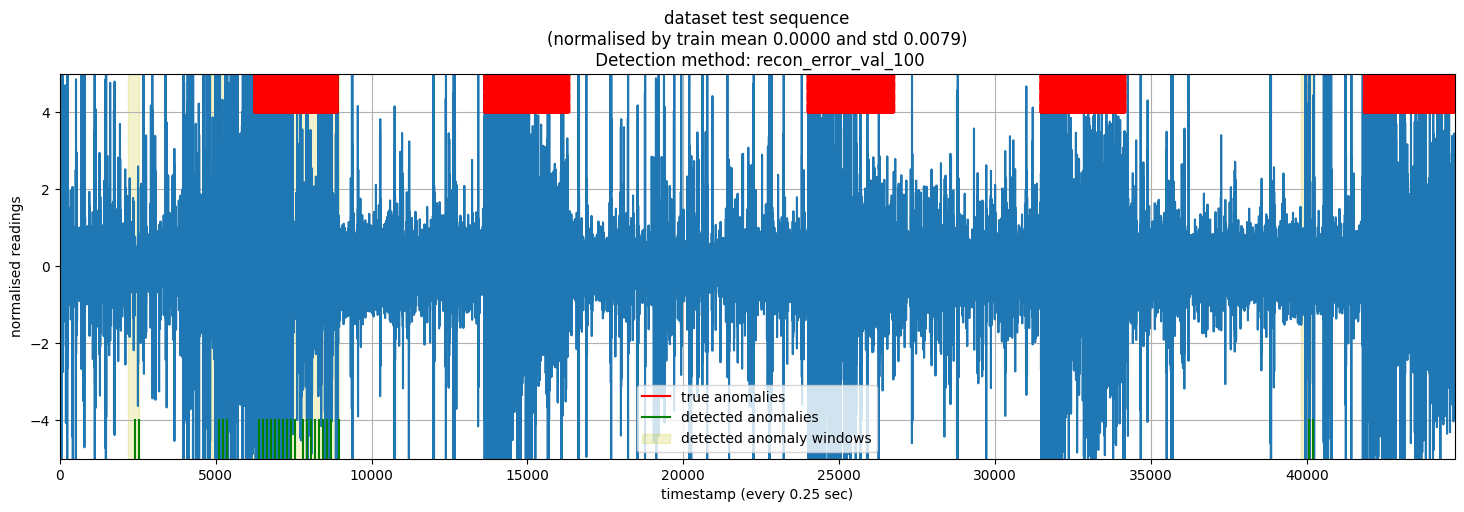

In [22]:
plot_detected_anomalies(idx_detection_augmented, 
                        config=config,
                        result=result, 
                        detection_method='recon_error_val_100',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)

In [23]:
percentile_list = np.arange(0, 100.1, 0.1)
threshold_list = np.percentile(test_score, percentile_list)

n_threshold = len(threshold_list)

precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)

precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)

for i, threshold in tqdm(enumerate(threshold_list)):
    #print(threshold_list[i])
    idx_detection_vae = return_anomaly_idx_by_threshold(test_score, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_vae, 
                                                                           anomaly_index_vae, 
                                                                           test_labels_vae)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_vae_augmented = augment_detected_idx(idx_detection_vae, anomaly_index_vae)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_vae_augmented, 
                                                                                       anomaly_index_vae, 
                                                                                       test_labels_vae)

1001it [00:00, 1026.37it/s]


In [24]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision) / n_threshold
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug) / n_threshold
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.7357859531772576
Best threshold is [13704.48520508 13722.73828613 13740.99136719]
At this threshold, precision is [0.59782609 0.59782609 0.59782609], recall is [0.95652174 0.95652174 0.95652174]
Average precision is 0.5551162920012289

Augmented detection:
Best F1 score is 0.7357859531772576
Best threshold is [13704.48520508 13722.73828613 13740.99136719]
At this threshold, precision is [0.59782609 0.59782609 0.59782609], recall is [0.95652174 0.95652174 0.95652174]
Average precision is 0.5551162920012289


In [25]:
# Now select a threshold
threshold = 13704.48520508

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_score, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_vae)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_vae, 
                                                                       test_labels_vae)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 13704.48520508

PR evaluation using augmented detection:
Precision: 0.5978260869565217
Recall: 0.9565217391304348
F1: 0.7357859531772576
TP: 110
FP: 74
FN: 5


Detected 20 sequences


/tmp/ipykernel_86064/4187010438.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/tmp/ipykernel_86064/4187010438.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))
/home/peunsu/ml_project/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


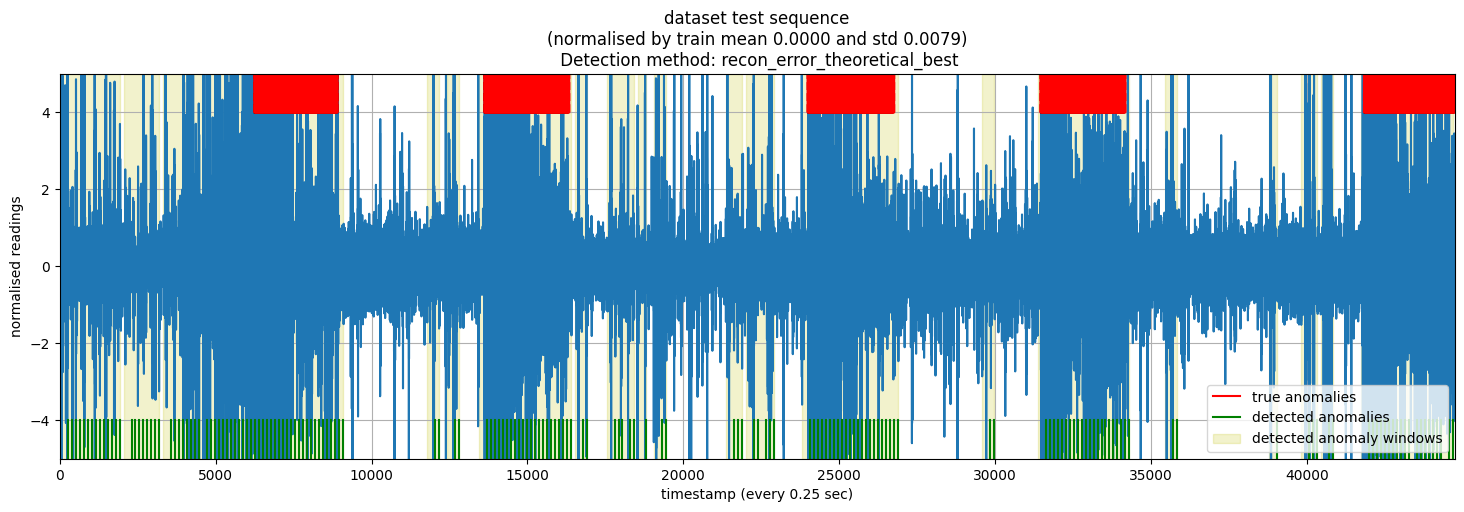

In [26]:
plot_detected_anomalies(idx_detection_augmented, 
                        config=config,
                        result=result, 
                        detection_method='recon_error_theoretical_best',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)